SIMPLE FEED FORWARD NETWORK

- Dataset file is in HDF5 fileformat which is Hierarchical Data Format (HDF).
- It contains multidimensional arrays of scientific data.
- H5 files are commonly used in aerospace, physics, engineering,finance, academic research, genomics, astronomy, electronics instruments, and medical fields.
- We make use of h5py package to import dataset.
- Pandas library is used to create a dataframe to display recall and precision for the 10 classes. Numpy is used to create matrix, random numbers, dot product, etc. matplotlib is used to plot image from the pixel data.


In [1]:
# import necessary packages 
  
import h5py
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import make_scorer, accuracy_score
from tensorflow.keras import regularizers, optimizers

from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

#import preprocessing

plt.rcParams['figure.figsize'] = (16.0, 4.0)

In [2]:
# set random seed
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

In [3]:
# read data 
file_hdf5 = h5py.File('Part - 4 - Autonomous_Vehicles_SVHN_single_grey1.h5', 'r')
file_hdf5

<HDF5 file "Part - 4 - Autonomous_Vehicles_SVHN_single_grey1.h5" (mode r)>

Access data file in read mode.

In [4]:
# Let us examine the data set as a Dataset object
file_hdf5.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

Based on our observation, there are six data set in the file. 
* X_test
* X_train 
* X_val 
* y_test 
* y_train 
* y_val

In [5]:
# The object we obtained isn’t an array, but an HDF5 dataset.
# Like NumPy arrays, datasets have both a shape and a data type:

X_train =file_hdf5['X_train'][:]
y_train =file_hdf5['y_train'][:]
X_test =file_hdf5['X_test'][:]
y_test =file_hdf5['y_test'][:]
X_val = file_hdf5['X_val'][:]
y_val = file_hdf5['y_val'][:]

file_hdf5.close() #close this file

In [6]:
# understand data shape of dataset

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_train.shape)
print('y_test:', y_train.shape)
print('X_val:', X_train.shape)
print('y_val:', y_train.shape)

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0] + X_val.shape[0]

print("Total Number of Images", num_images)

X_train: (42000, 32, 32)
y_train: (42000,)
X_test: (42000, 32, 32)
y_test: (42000,)
X_val: (42000, 32, 32)
y_val: (42000,)
Total Number of Images 120000


In [7]:
X_train.shape

(42000, 32, 32)

In [8]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32):
            ax.imshow(img[i],cmap='gray')
        else:
            ax.imshow(img[i,:,:,0],cmap='gray')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

Label for image: 4


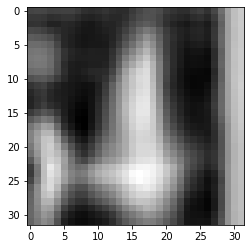

In [9]:
plt.figure()
plt.imshow(X_train[50], cmap='gray')

print("Label for image: {}".format(y_train[50]))

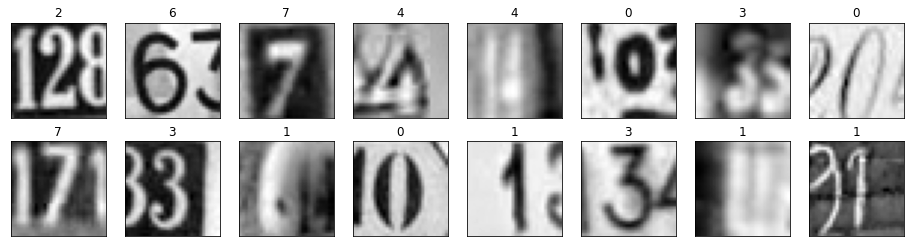

In [10]:
# Plot some training set images
plot_images(X_train, y_train, 2, 8)

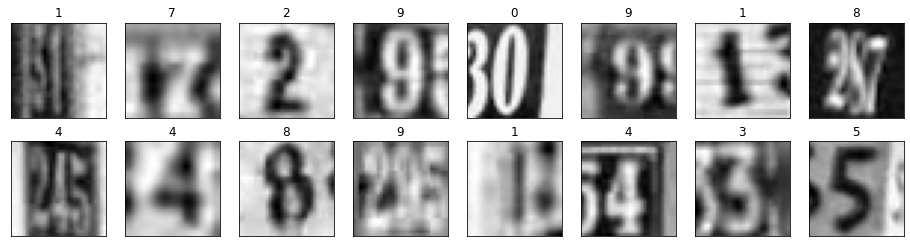

In [11]:
# Plot some test set images
plot_images(X_test, y_test, 2, 8)

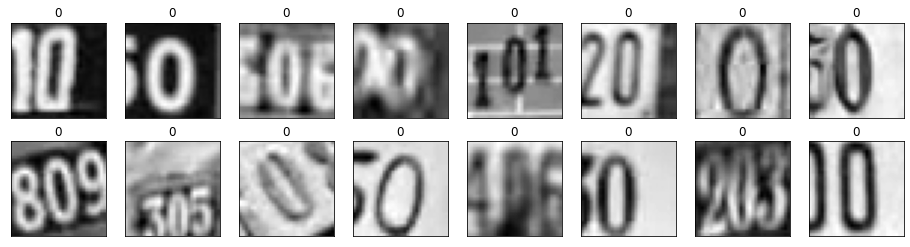

In [12]:
# Plot some validation set images
plot_images(X_val, y_val, 2, 8)

In [13]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

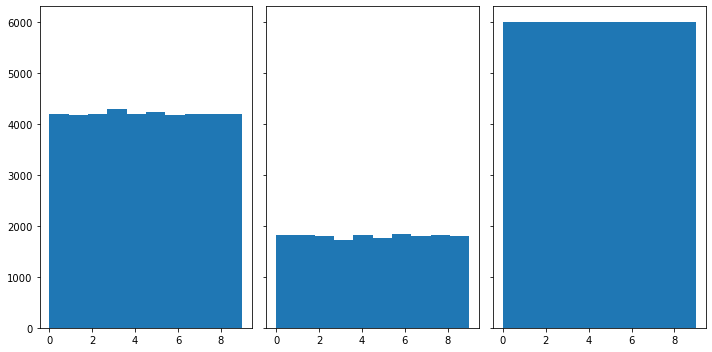

In [14]:
n_bins = 10
fig, axs = plt.subplots(1, 3, figsize=(10, 5) ,sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(y_train, bins=n_bins)
axs[1].hist(y_test, bins=n_bins)
axs[2].hist(y_val , bins = n_bins)


Reshape the features from 32×32 into a single dimensional array of 1024 features in total. Normalize the data from 0-255 to 0-1 by dividing the inputs by 255. The denominator should be a float, else the output would become 0.

In [15]:
# function to preprocess the image before feeding it to algorithm

def prep_data_keras(img_data):
    # Converting everything to floats
    img_data = img_data.astype('float32')
    
    # Normalizing values between 0 and 1
    img_data /= 255
    
    return img_data

In [16]:
train_images = prep_data_keras(X_train)
test_images = prep_data_keras(X_test)
valid_images = prep_data_keras(X_val)

In [17]:
print(train_images.shape)
print(test_images.shape)
print(valid_images.shape)

(42000, 32, 32)
(18000, 32, 32)
(60000, 32, 32)


We should check the proportion of each class in the target variable to ensure there is no imbalance in the ground truth values.
 

In [18]:
for i in range(0,10): 
    print("Label: {0} | Value % = {1}".format( i, (y_train[y_train == i].size / y_train.size)*100) ) 



Label: 0 | Value % = 9.966666666666667
Label: 1 | Value % = 9.933333333333334
Label: 2 | Value % = 9.992857142857142
Label: 3 | Value % = 10.192857142857143
Label: 4 | Value % = 9.971428571428572
Label: 5 | Value % = 10.076190476190476
Label: 6 | Value % = 9.923809523809524
Label: 7 | Value % = 9.980952380952381
Label: 8 | Value % = 9.971428571428572
Label: 9 | Value % = 9.99047619047619


We observe that all the classes have almost equal number of images. Let's now encode the target variable useing one hot encoding form tensorflow 'to_categorical'

In [19]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

print("Shape of y_train:", y_train.shape)
print("One value of y_train:", y_train[0])

Shape of y_train: (42000, 10)
One value of y_train: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


Label:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


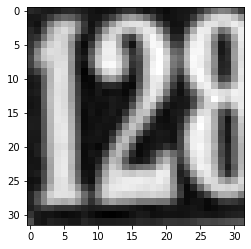

In [20]:
# let's see example
print("Label: ", y_train[0])
plt.imshow(X_train[0], cmap='gray')


we observe that the image with number 2 is labeled 0010000000 after encoding. Now let's reshape the images to feed it into network.

In [21]:
X_train = train_images.reshape(42000, 1024)
print(X_train.shape)
X_test = test_images.reshape(18000, 1024)
print(X_test.shape)
X_val = valid_images.reshape(60000, 1024)
print(X_val.shape)




(42000, 1024)
(18000, 1024)
(60000, 1024)


Class distribution looks fine for all classes.

In [22]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# let's build the classifier FNN
# create model

def train_and_test_loop(iterations, lr, Lambda, verb=True):

    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10
        
    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=((1024,)), activation='relu'))
    model.add(Dense(hidden_nodes, activation='relu'))
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit the model
    model.fit(X_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)

Fully connected Network is built with two hidden layers and 250 nodes each with relu as activation function and an output layer with 10 neurons and activation function softmax.  

In [23]:
def train_and_test_loop1(iterations, lr, Lambda, verb=True):

    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 256
    output_nodes = 10

    model = Sequential()
    model.add(Dense(hidden_nodes, input_shape=(1024,), activation='relu'))
    model.add(Dense(hidden_nodes, activation='relu'))
    model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))
    
    sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    # Fit the model
    model.fit(X_train, y_train, epochs=iterations, batch_size=1000, verbose= 1)
    score = model.evaluate(X_train, y_train, verbose=0)
    
    return score


Lets set hyper parametr manually and check the performanec of the fnn classifier.

In [24]:
lr = 0.00001
Lambda = 0
train_and_test_loop(10, lr, Lambda)

2021-11-22 09:25:23.435719: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-22 09:25:23.894632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
42/42 [==============================] - 2s 18ms/step - loss: 2.4686 - accuracy: 0.1007
Epoch 2/10
42/42 [==============================] - 1s 18ms/step - loss: 2.4409 - accuracy: 0.1008
Epoch 3/10
42/42 [==============================] - 1s 19ms/step - loss: 2.4185 - accuracy: 0.1007
Epoch 4/10
42/42 [==============================] - 1s 19ms/step - loss: 2.4009 - accuracy: 0.1007
Epoch 5/10
42/42 [==============================] - 1s 21ms/step - loss: 2.3870 - accuracy: 0.1007
Epoch 6/10
42/42 [==============================] - 1s 22ms/step - loss: 2.3758 - accuracy: 0.1008
Epoch 7/10
42/42 [==============================] - 1s 20ms/step - loss: 2.3666 - accuracy: 0.1007
Epoch 8/10
42/42 [==============================] - 1s 19ms/step - loss: 2.3589 - accuracy: 0.1003
Epoch 9/10
42/42 [==============================] - 1s 19ms/step - loss: 2.3525 - accuracy: 0.1002
Epoch 10/10
42/42 [==============================] - 1s 20ms/step - loss: 2.3470 - accuracy: 0.1002


We observe that the acuuracy gradually increase and the loss saturates to 2.3 after epoch 5

In [25]:
lr = 0.00001
Lambda = 1e3
train_and_test_loop(15, lr, Lambda)

Epoch 1/15
42/42 [==============================] - 1s 17ms/step - loss: 3333.4956 - accuracy: 0.0941
Epoch 2/15
42/42 [==============================] - 1s 17ms/step - loss: 40.6568 - accuracy: 0.0957
Epoch 3/15
42/42 [==============================] - 1s 18ms/step - loss: 2.6183 - accuracy: 0.0955
Epoch 4/15
42/42 [==============================] - 1s 18ms/step - loss: 2.3053 - accuracy: 0.0988
Epoch 5/15
42/42 [==============================] - 1s 18ms/step - loss: 2.3026 - accuracy: 0.0986
Epoch 6/15
42/42 [==============================] - 1s 18ms/step - loss: 2.3026 - accuracy: 0.0988
Epoch 7/15
42/42 [==============================] - 1s 18ms/step - loss: 2.3026 - accuracy: 0.0999
Epoch 8/15
42/42 [==============================] - 1s 17ms/step - loss: 2.3026 - accuracy: 0.1012
Epoch 9/15
42/42 [==============================] - 1s 17ms/step - loss: 2.3026 - accuracy: 0.0998
Epoch 10/15
42/42 [==============================] - 1s 18ms/step - loss: 2.3026 - accuracy: 0.1011
Epoch

we don't observe any improvement in the loss.

In [26]:
lr = 1e4
Lambda = 1e-7
train_and_test_loop(20, lr, Lambda)

Epoch 1/20
42/42 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.1011                 
Epoch 2/20
42/42 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.0997
Epoch 3/20
42/42 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.0997
Epoch 4/20
42/42 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.0997
Epoch 5/20
42/42 [==============================] - 1s 18ms/step - loss: nan - accuracy: 0.0997
Epoch 6/20
42/42 [==============================] - 1s 18ms/step - loss: nan - accuracy: 0.0997
Epoch 7/20
42/42 [==============================] - 1s 19ms/step - loss: nan - accuracy: 0.0997
Epoch 8/20
42/42 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.0997
Epoch 9/20
42/42 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.0997
Epoch 10/20
42/42 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.0997
Epoch 11/20
42/42 [===

In [27]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-7.0, 3.0))
    Lambda = math.pow(10, np.random.uniform(-7,-2))
    best_acc = train_and_test_loop1(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Epoch 1/100
42/42 [==============================] - 1s 18ms/step - loss: 2.4427 - accuracy: 0.0990
Epoch 2/100
42/42 [==============================] - 1s 17ms/step - loss: 2.4171 - accuracy: 0.1026
Epoch 3/100
42/42 [==============================] - 1s 18ms/step - loss: 2.4133 - accuracy: 0.1053
Epoch 4/100
42/42 [==============================] - 1s 17ms/step - loss: 2.4105 - accuracy: 0.1099
Epoch 5/100
42/42 [==============================] - 1s 17ms/step - loss: 2.4076 - accuracy: 0.1161
Epoch 6/100
42/42 [==============================] - 1s 17ms/step - loss: 2.4049 - accuracy: 0.1210
Epoch 7/100
42/42 [==============================] - 1s 17ms/step - loss: 2.4026 - accuracy: 0.1268
Epoch 8/100
42/42 [==============================] - 1s 17ms/step - loss: 2.4005 - accuracy: 0.1321
Epoch 9/100
42/42 [==============================] - 1s 17ms/step - loss: 2.3985 - accuracy: 0.1341
Epoch 10/100
42/42 [==============================] - 1s 17ms/step - loss: 2.3965 - accuracy: 0.1384

42/42 [==============================] - 1s 17ms/step - loss: 2.2165 - accuracy: 0.3851
Epoch 83/100
42/42 [==============================] - 1s 17ms/step - loss: 2.2123 - accuracy: 0.3827
Epoch 84/100
42/42 [==============================] - 1s 16ms/step - loss: 2.2079 - accuracy: 0.3880
Epoch 85/100
42/42 [==============================] - 1s 16ms/step - loss: 2.2035 - accuracy: 0.3943
Epoch 86/100
42/42 [==============================] - 1s 16ms/step - loss: 2.1989 - accuracy: 0.3912
Epoch 87/100
42/42 [==============================] - 1s 17ms/step - loss: 2.1943 - accuracy: 0.3941
Epoch 88/100
42/42 [==============================] - 1s 17ms/step - loss: 2.1898 - accuracy: 0.3975
Epoch 89/100
42/42 [==============================] - 1s 17ms/step - loss: 2.1849 - accuracy: 0.4016
Epoch 90/100
42/42 [==============================] - 1s 17ms/step - loss: 2.1801 - accuracy: 0.3984
Epoch 91/100
42/42 [==============================] - 1s 16ms/step - loss: 2.1751 - accuracy: 0.4047
Epo

42/42 [==============================] - 1s 17ms/step - loss: 6.1920 - accuracy: 0.0973
Epoch 60/100
42/42 [==============================] - 1s 18ms/step - loss: 5.0174 - accuracy: 0.0985
Epoch 61/100
42/42 [==============================] - 1s 18ms/step - loss: 4.1992 - accuracy: 0.0995
Epoch 62/100
42/42 [==============================] - 1s 20ms/step - loss: 3.6298 - accuracy: 0.0989
Epoch 63/100
42/42 [==============================] - 1s 21ms/step - loss: 3.2305 - accuracy: 0.1008
Epoch 64/100
42/42 [==============================] - 1s 21ms/step - loss: 2.9512 - accuracy: 0.0995
Epoch 65/100
42/42 [==============================] - 1s 20ms/step - loss: 2.7561 - accuracy: 0.1015
Epoch 66/100
42/42 [==============================] - 1s 19ms/step - loss: 2.6222 - accuracy: 0.0984
Epoch 67/100
42/42 [==============================] - 1s 19ms/step - loss: 2.5259 - accuracy: 0.0980
Epoch 68/100
42/42 [==============================] - 1s 20ms/step - loss: 2.4604 - accuracy: 0.0983
Epo

42/42 [==============================] - 1s 19ms/step - loss: 2.3198 - accuracy: 0.0982
Epoch 40/100
42/42 [==============================] - 1s 17ms/step - loss: 2.3194 - accuracy: 0.0981
Epoch 41/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3189 - accuracy: 0.0984
Epoch 42/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3185 - accuracy: 0.0986
Epoch 43/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3181 - accuracy: 0.0985
Epoch 44/100
42/42 [==============================] - 1s 22ms/step - loss: 2.3177 - accuracy: 0.0983
Epoch 45/100
42/42 [==============================] - 1s 17ms/step - loss: 2.3173 - accuracy: 0.0984
Epoch 46/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3170 - accuracy: 0.0987
Epoch 47/100
42/42 [==============================] - 1s 24ms/step - loss: 2.3166 - accuracy: 0.0991
Epoch 48/100
42/42 [==============================] - 1s 18ms/step - loss: 2.3163 - accuracy: 0.0990
Epo

42/42 [==============================] - 1s 18ms/step - loss: 2.3650 - accuracy: 0.1000
Epoch 20/100
42/42 [==============================] - 1s 19ms/step - loss: 2.3649 - accuracy: 0.1000
Epoch 21/100
42/42 [==============================] - 1s 21ms/step - loss: 2.3648 - accuracy: 0.1001
Epoch 22/100
42/42 [==============================] - 1s 18ms/step - loss: 2.3647 - accuracy: 0.1001
Epoch 23/100
42/42 [==============================] - 1s 19ms/step - loss: 2.3646 - accuracy: 0.1001
Epoch 24/100
42/42 [==============================] - 1s 18ms/step - loss: 2.3646 - accuracy: 0.1002
Epoch 25/100
42/42 [==============================] - 1s 22ms/step - loss: 2.3645 - accuracy: 0.1002
Epoch 26/100
42/42 [==============================] - 1s 25ms/step - loss: 2.3644 - accuracy: 0.1002
Epoch 27/100
42/42 [==============================] - 1s 19ms/step - loss: 2.3643 - accuracy: 0.1003
Epoch 28/100
42/42 [==============================] - 1s 17ms/step - loss: 2.3642 - accuracy: 0.1003
Epo

42/42 [==============================] - 1s 16ms/step - loss: 2.3595 - accuracy: 0.1016
Try 4/100: Best_val_acc: [2.35951566696167, 0.10166666656732559], lr: 3.809220577048034e-07, Lambda: 0.0021423021757741053

Epoch 1/100
42/42 [==============================] - 1s 15ms/step - loss: 2.2717 - accuracy: 0.1679
Epoch 2/100
42/42 [==============================] - 1s 15ms/step - loss: 2.0535 - accuracy: 0.2840
Epoch 3/100
42/42 [==============================] - 1s 15ms/step - loss: 2.1527 - accuracy: 0.2411
Epoch 4/100
42/42 [==============================] - 1s 16ms/step - loss: 2.0713 - accuracy: 0.2672
Epoch 5/100
42/42 [==============================] - 1s 16ms/step - loss: 1.9434 - accuracy: 0.3131
Epoch 6/100
42/42 [==============================] - 1s 17ms/step - loss: 1.6265 - accuracy: 0.4355
Epoch 7/100
42/42 [==============================] - 1s 15ms/step - loss: 1.7774 - accuracy: 0.3867
Epoch 8/100
42/42 [==============================] - 1s 16ms/step - loss: 1.4433 - accur

42/42 [==============================] - 1s 17ms/step - loss: 0.5495 - accuracy: 0.8352
Epoch 81/100
42/42 [==============================] - 1s 17ms/step - loss: 0.5380 - accuracy: 0.8387
Epoch 82/100
42/42 [==============================] - 1s 16ms/step - loss: 0.5472 - accuracy: 0.8374
Epoch 83/100
42/42 [==============================] - 1s 16ms/step - loss: 0.5301 - accuracy: 0.8418
Epoch 84/100
42/42 [==============================] - 1s 15ms/step - loss: 0.5290 - accuracy: 0.8431
Epoch 85/100
42/42 [==============================] - 1s 15ms/step - loss: 0.5149 - accuracy: 0.8470
Epoch 86/100
42/42 [==============================] - 1s 15ms/step - loss: 0.5410 - accuracy: 0.8380
Epoch 87/100
42/42 [==============================] - 1s 15ms/step - loss: 0.5285 - accuracy: 0.8426
Epoch 88/100
42/42 [==============================] - 1s 18ms/step - loss: 0.5365 - accuracy: 0.8392
Epoch 89/100
42/42 [==============================] - 1s 17ms/step - loss: 0.5238 - accuracy: 0.8444
Epo

42/42 [==============================] - 1s 18ms/step - loss: 2.4960 - accuracy: 0.0993
Epoch 61/100
42/42 [==============================] - 1s 18ms/step - loss: 2.4958 - accuracy: 0.0993
Epoch 62/100
42/42 [==============================] - 1s 18ms/step - loss: 2.4957 - accuracy: 0.0993
Epoch 63/100
42/42 [==============================] - 1s 17ms/step - loss: 2.4956 - accuracy: 0.0993
Epoch 64/100
42/42 [==============================] - 1s 17ms/step - loss: 2.4955 - accuracy: 0.0993
Epoch 65/100
42/42 [==============================] - 1s 17ms/step - loss: 2.4954 - accuracy: 0.0993
Epoch 66/100
42/42 [==============================] - 1s 16ms/step - loss: 2.4953 - accuracy: 0.0993
Epoch 67/100
42/42 [==============================] - 1s 18ms/step - loss: 2.4952 - accuracy: 0.0993
Epoch 68/100
42/42 [==============================] - 1s 18ms/step - loss: 2.4951 - accuracy: 0.0993
Epoch 69/100
42/42 [==============================] - 1s 19ms/step - loss: 2.4950 - accuracy: 0.0993
Epo

42/42 [==============================] - 1s 21ms/step - loss: 3963757643637222014976.0000 - accuracy: 0.1004
Epoch 34/100
42/42 [==============================] - 1s 18ms/step - loss: 3804505575738797195264.0000 - accuracy: 0.1019
Epoch 35/100
42/42 [==============================] - 1s 18ms/step - loss: 3651657626510493220864.0000 - accuracy: 0.1016
Epoch 36/100
42/42 [==============================] - 1s 18ms/step - loss: 3504957653723503394816.0000 - accuracy: 0.0989
Epoch 37/100
42/42 [==============================] - 1s 16ms/step - loss: 3364155426123531943936.0000 - accuracy: 0.1028
Epoch 38/100
42/42 [==============================] - 1s 16ms/step - loss: 3229016475054978891776.0000 - accuracy: 0.1003
Epoch 39/100
42/42 [==============================] - 1s 17ms/step - loss: 3099310272511918211072.0000 - accuracy: 0.1005
Epoch 40/100
42/42 [==============================] - 1s 16ms/step - loss: 2974819801287305986048.0000 - accuracy: 0.1005
Epoch 41/100
42/42 [=================

42/42 [==============================] - 1s 17ms/step - loss: 255015695581156737024.0000 - accuracy: 0.1006
Try 7/100: Best_val_acc: [2.4971562732281135e+20, 0.09933333098888397], lr: 21.106995036049593, Lambda: 1.1526449540315615e-06

Epoch 1/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3799 - accuracy: 0.0990
Epoch 2/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3729 - accuracy: 0.0988
Epoch 3/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3664 - accuracy: 0.0987
Epoch 4/100
42/42 [==============================] - 1s 15ms/step - loss: 2.3608 - accuracy: 0.0985
Epoch 5/100
42/42 [==============================] - 1s 17ms/step - loss: 2.3558 - accuracy: 0.0987
Epoch 6/100
42/42 [==============================] - 1s 18ms/step - loss: 2.3514 - accuracy: 0.0983
Epoch 7/100
42/42 [==============================] - 1s 26ms/step - loss: 2.3475 - accuracy: 0.0991
Epoch 8/100
42/42 [==============================] - 1s 24ms/ste

42/42 [==============================] - 1s 17ms/step - loss: 2.3047 - accuracy: 0.0999
Epoch 80/100
42/42 [==============================] - 1s 21ms/step - loss: 2.3047 - accuracy: 0.0999
Epoch 81/100
42/42 [==============================] - 1s 20ms/step - loss: 2.3046 - accuracy: 0.1002
Epoch 82/100
42/42 [==============================] - 1s 18ms/step - loss: 2.3046 - accuracy: 0.1004
Epoch 83/100
42/42 [==============================] - 1s 18ms/step - loss: 2.3045 - accuracy: 0.1005
Epoch 84/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3045 - accuracy: 0.1008
Epoch 85/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3044 - accuracy: 0.1009
Epoch 86/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3044 - accuracy: 0.1010
Epoch 87/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3044 - accuracy: 0.1008
Epoch 88/100
42/42 [==============================] - 1s 16ms/step - loss: 2.3043 - accuracy: 0.1010
Epo

42/42 [==============================] - 1s 19ms/step - loss: 2.2841 - accuracy: 0.1409
Epoch 60/100
42/42 [==============================] - 1s 19ms/step - loss: 2.2838 - accuracy: 0.1401
Epoch 61/100
42/42 [==============================] - 1s 18ms/step - loss: 2.2835 - accuracy: 0.1415
Epoch 62/100
42/42 [==============================] - 1s 17ms/step - loss: 2.2832 - accuracy: 0.1429
Epoch 63/100
42/42 [==============================] - 1s 19ms/step - loss: 2.2829 - accuracy: 0.1443
Epoch 64/100
42/42 [==============================] - 1s 19ms/step - loss: 2.2826 - accuracy: 0.1450
Epoch 65/100
42/42 [==============================] - 1s 20ms/step - loss: 2.2823 - accuracy: 0.1456
Epoch 66/100
42/42 [==============================] - 1s 18ms/step - loss: 2.2820 - accuracy: 0.1463
Epoch 67/100
42/42 [==============================] - 1s 17ms/step - loss: 2.2817 - accuracy: 0.1480
Epoch 68/100
42/42 [==============================] - 1s 18ms/step - loss: 2.2814 - accuracy: 0.1471
Epo

In [28]:
# hyperparameters
iterations = 50
learning_rate = 0.0001102611276151
hidden_nodes = 256
output_nodes = 10
Lambda: 4.20515645091387e-05

final_model = Sequential()
final_model.add(Dense(hidden_nodes, input_shape=(1024,), activation='relu'))
final_model.add(Dense(hidden_nodes, activation='relu'))
final_model.add(Dense(hidden_nodes, activation='relu'))
final_model.add(Dense(output_nodes, activation='softmax', kernel_regularizer=regularizers.l2(Lambda)))

sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9)
# Compile model
final_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
# Fit the model


history = final_model.fit(X_train, y_train,
          batch_size      = 100,
          epochs          = iterations,
          validation_data = (X_val, y_val),
          shuffle         = True,
          verbose=0) #for visualization

In [29]:
final_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_38 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_39 (Dense)             (None, 10)                2570      
Total params: 396,554
Trainable params: 396,554
Non-trainable params: 0
_________________________________________________________________


In [30]:
final_model.evaluate(X_test, y_test)

563/563 [==============================] - 1s 2ms/step - loss: 1.8049 - accuracy: 0.4612


[1.8048585653305054, 0.4611666798591614]

In [31]:
print(history.params)

{'verbose': 0, 'epochs': 50, 'steps': 420}


In [32]:
# check the keys of history object
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


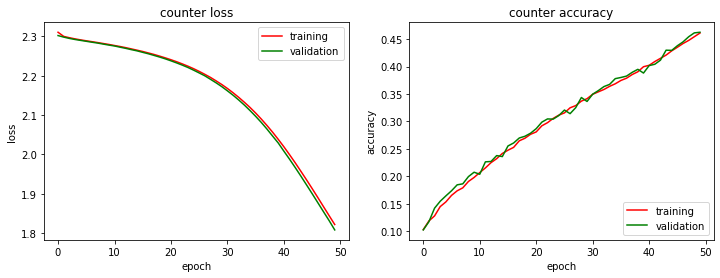

In [33]:
# plot loss
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
ctl_plot = plt.plot(history.history['loss'], 'r', label='training')
cvl_plot = plt.plot(history.history['val_loss'], 'g', label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('counter loss')
plt.legend()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='training')
plt.plot(history.history['val_accuracy'], 'g', label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('counter accuracy')
plt.legend(loc=4)

we observe that the model performs equally on the training data and validation data. Confirming that the model is generaising well without underfitting or over fitting.

In [34]:
# lets compare the score

scores=[]

score = final_model.evaluate(X_train, y_train, verbose=0)
scores.append(score)
score = final_model.evaluate(X_val,y_val, verbose=0)
scores.append(score)
score = final_model.evaluate(X_test,y_test, verbose=0)
scores.append(score)

print('Training dataset:- Loss is ', scores[0][0], 'accuracy is ', str(round(scores[0][1], 2)))
print('Validation dataset:- Loss is ', scores[1][0], 'accuracy is ',str(round(scores[1][1], 2)))
print('Testing dataset:- Loss is ', scores[2][0], 'accuracy is ', str(round(scores[2][1],2)))

Training dataset:- Loss is  1.8089900016784668 accuracy is  0.46
Validation dataset:- Loss is  1.8077507019042969 accuracy is  0.46
Testing dataset:- Loss is  1.8048585653305054 accuracy is  0.46


Let's transoform binary encoded to its repective column value to analyse model classification result

In [35]:
y_test = np.argmax(y_test, axis=1)

In [36]:
# make a prediction
ypred = final_model.predict_classes(X_test)
# show the inputs and predicted outputs
for i in range(len(X_test[0:5])):
    print("X=%s, Predicted=%s\n" % (X_test[i], y_test[i]))
   

X=[0.15905097 0.18349686 0.19206432 ... 0.43143883 0.4360851  0.44780627], Predicted=1

X=[0.45161137 0.44769022 0.44376904 ... 0.1652502  0.18922432 0.20883021], Predicted=7

X=[0.52256864 0.52834475 0.53456783 ... 0.50266707 0.5012169  0.5027937 ], Predicted=2

X=[0.31330708 0.37649295 0.40366313 ... 0.3405196  0.41574708 0.48196   ], Predicted=9

X=[0.5313804  0.52745926 0.5136294  ... 0.8675161  0.8675161  0.86359495], Predicted=0



Actual Label:  8
Predicte Label 6


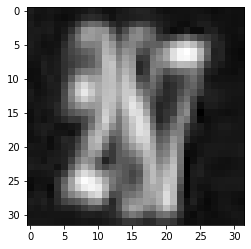

In [37]:
# let's see some example to observe the prediction

print("Actual Label: ", y_test[7])
print("Predicte Label", ypred[7])
plt.imshow(X_test[7].reshape(32,32), cmap='gray')



Since the image is noisy the model is not able to predict its actual label. Predicted as 6 where as actual label is 8

Actual Label:  6
Predicte Label 6


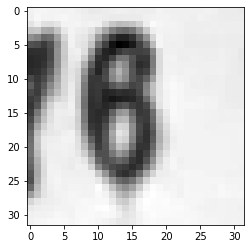

In [38]:
print("Actual Label: ", y_test[167])
print("Predicte Label", ypred[167])
plt.imshow(X_test[167].reshape(32,32), cmap='gray')




Since the above image is less noisier compared to previous image. the model is able to correctly predict the label 6.

In [39]:
# lets plot confusion matrices and see classification details

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predicted class equals the true clas

cm = confusion_matrix(y_test , ypred)


In [40]:
cm

array([[1100,   65,   47,  102,   90,   16,  233,   34,   28,   99],
       [ 106, 1216,   74,  118,  135,   22,   41,   88,   12,   16],
       [  64,  153,  767,  162,   69,   25,   29,  428,   21,   85],
       [  94,  231,  284,  606,   96,   88,   25,  130,   84,   81],
       [  72,  156,   33,   75, 1326,   14,   77,    9,   15,   35],
       [ 185,  157,   76,  280,  126,  212,  131,   46,  226,  329],
       [ 379,   91,   43,   58,  203,   27,  903,   19,   59,   50],
       [  74,  136,  195,  110,   38,   29,   43, 1145,    7,   31],
       [ 338,  105,   55,  121,  224,   87,  377,   29,  283,  193],
       [ 350,  134,   93,  178,  122,   37,   65,   61,   21,  743]])

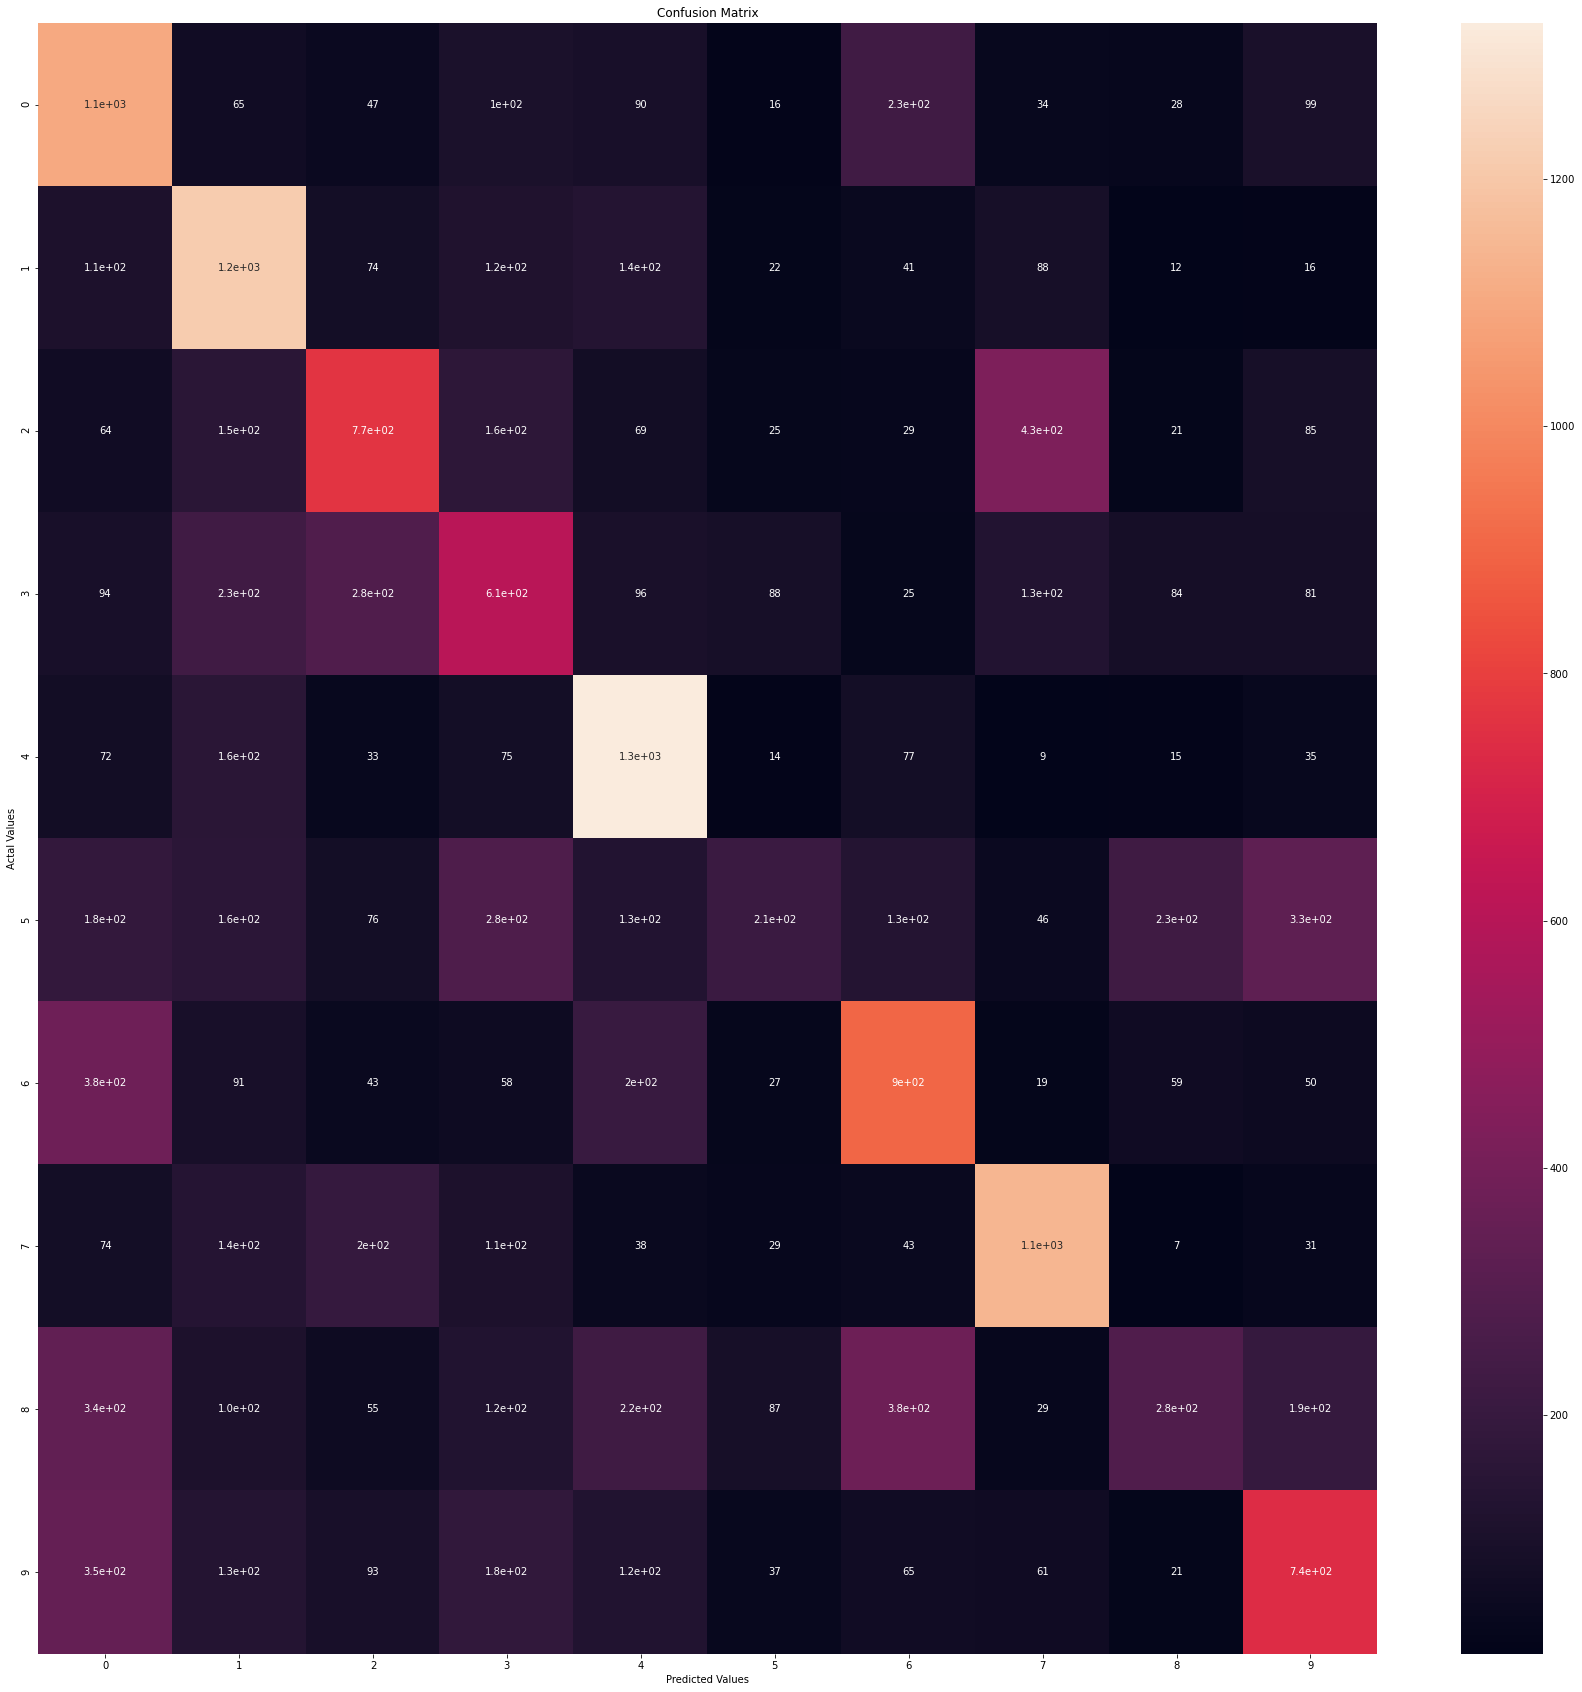

In [41]:
#Plotting the confusion matrix

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


In [42]:
print(classification_report(y_test , ypred))


              precision    recall  f1-score   support

           0       0.40      0.61      0.48      1814
           1       0.50      0.67      0.57      1828
           2       0.46      0.43      0.44      1803
           3       0.33      0.35      0.34      1719
           4       0.55      0.73      0.63      1812
           5       0.38      0.12      0.18      1768
           6       0.47      0.49      0.48      1832
           7       0.58      0.63      0.60      1808
           8       0.37      0.16      0.22      1812
           9       0.45      0.41      0.43      1804

    accuracy                           0.46     18000
   macro avg       0.45      0.46      0.44     18000
weighted avg       0.45      0.46      0.44     18000



We observe that model is able to predict 0 , 1 ,4 , 7 labels more accurately. The model is failing to predict other labels especially 8 , 5 and able to predict other labels moderately.
Since its an image classification. FNN's does not capture / are able to learn relevant features from an image /video at different levels similar to a human brain compared to CNN. 

Feature learning is done better by CNN's.CNNs are very good feature extractors. This means that you can extract useful attributes from an already trained CNN with its trained weights by feeding your data on each level and tune the CNN a bit for the specific task. Eg : Add a classifier after the last layer with labels specific to the task. This is also called pre-training and CNNs are very efficient in such tasks compared to NNs. Another advantage of this pre-training is we avoid training of CNN and save memory, time. The only thing you have to train is the classifier at the end for your labels.

More of image preprocessing such as affine transformation can be done to improve the accuracy of model. 